In [1]:
import xarray as xr
from dask.distributed import LocalCluster, Client
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

In [ ]:
client = Client(LocalCluster())

In [2]:
datapath = '/lus/scratch/shao/data/NEP36_extremes/'
cluster_files = glob.glob('output_data/cluster*.nc')
clusters_ds = [ xr.open_dataset(file, chunks={'time':439}, engine='h5netcdf') for file in cluster_files ]

In [43]:
plot_clusters = [0, 1]

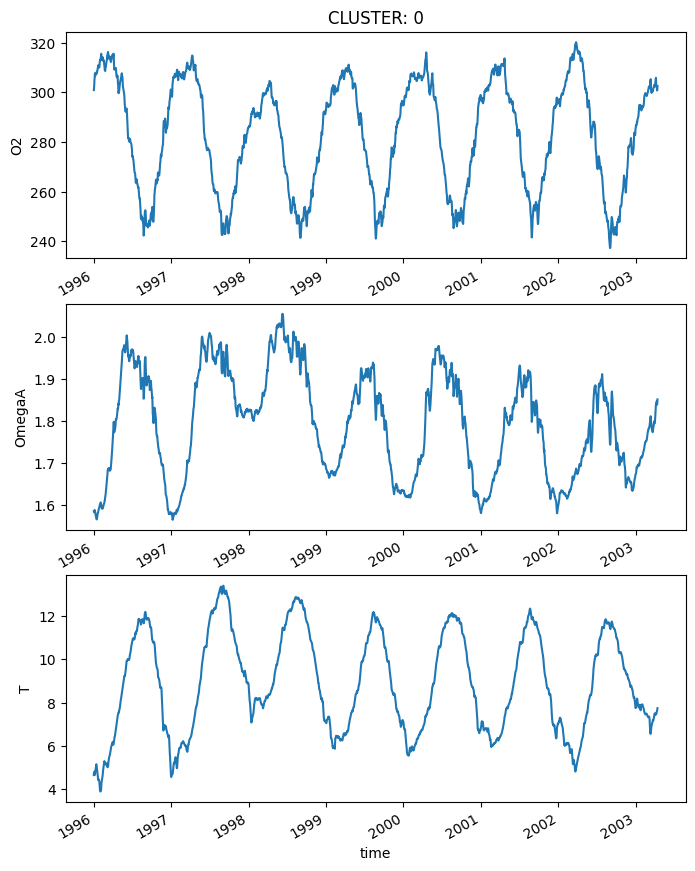

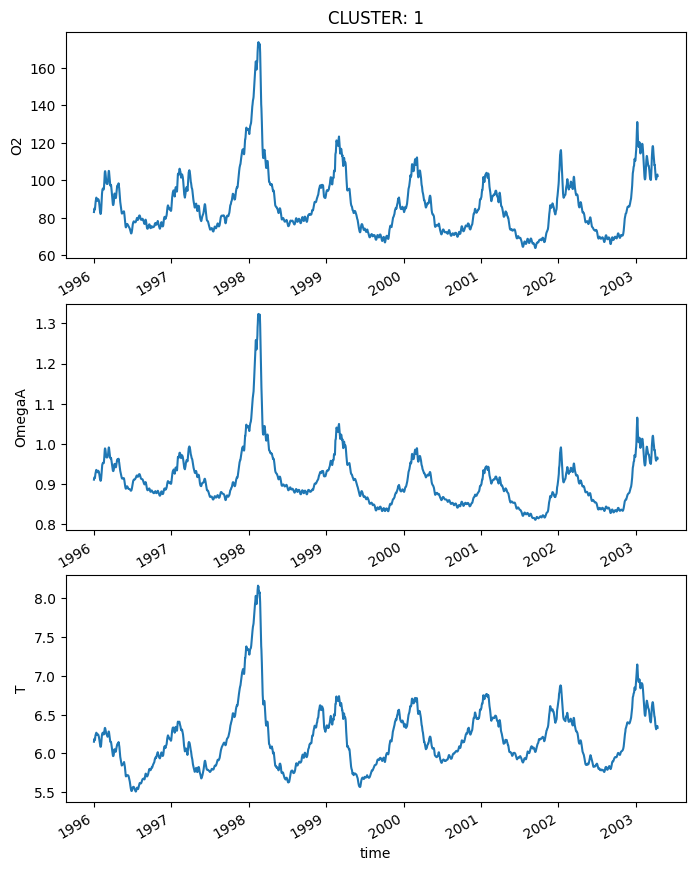

In [44]:
# Plot timeseries of all the relevant variables
timeseries_vars = [
    'O2',
    'OmegaA',
    'T'
]

for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))    
        for idx, var in enumerate(timeseries_vars):        
            plt.subplot(3,1,idx+1)
            cluster_ds[var].mean('stacked_y_x').plot()
            if idx == 0:
                plt.title(f'CLUSTER: {cluster_label}')
    

In [45]:
# Split by upwelling season
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

def filter_by_season_and_values(ds,month_range):       
    ds_out = ds.where(ds['time.month'].isin(month_range),drop=True)
    return ds_out

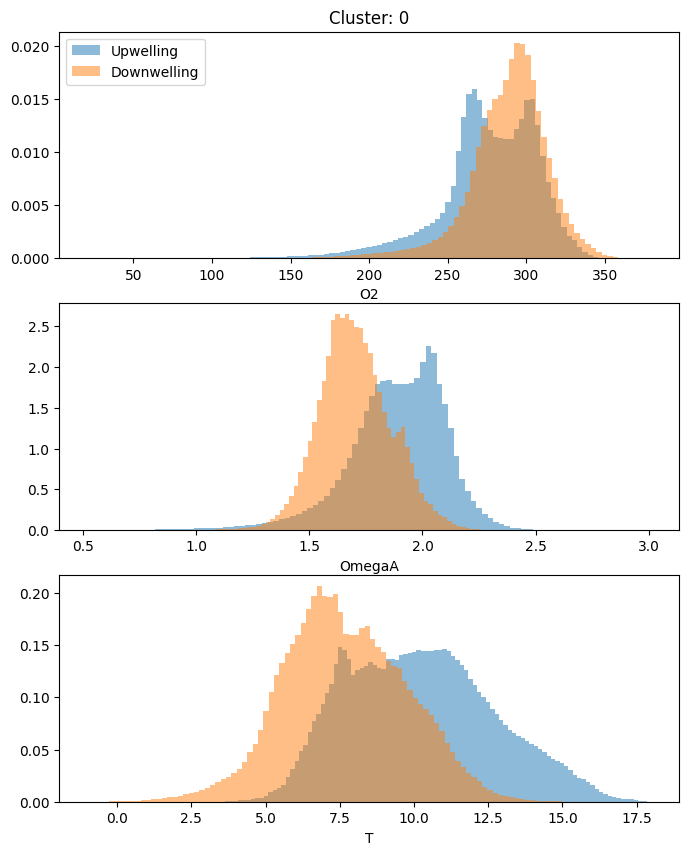

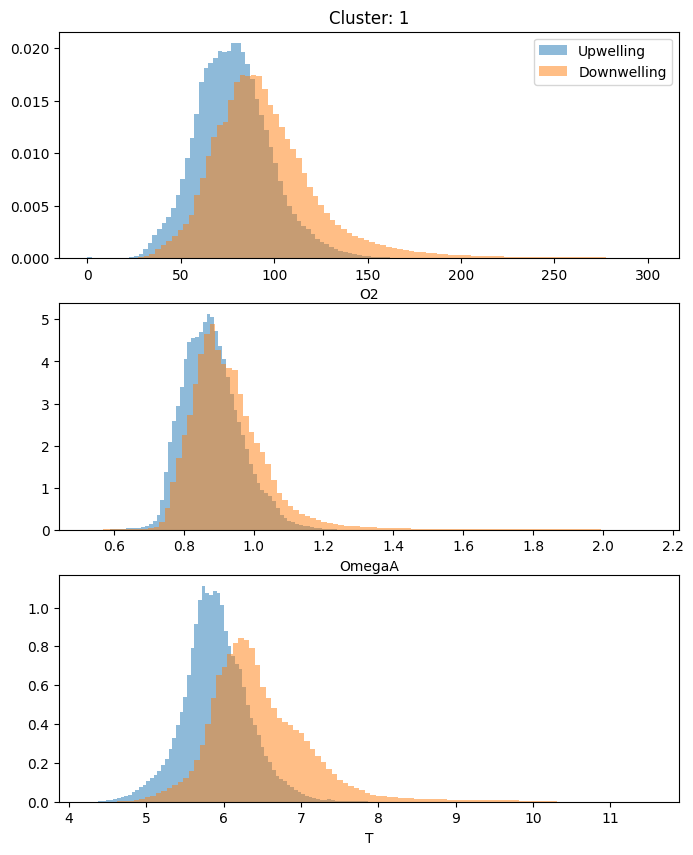

In [51]:
downwelling = {}
upwelling = {}

for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))
        ds_months = cluster_ds.groupby('time.month')    
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)
        downwelling[cluster_label] = downwelling_ds.copy()
        upwelling[cluster_label] = upwelling_ds.copy()
        for idx, var in enumerate(timeseries_vars):         
            plt.subplot(3,1,idx+1)
            plt.hist(upwelling_ds[var].to_numpy().flatten(),label='Upwelling', **hist_kwargs)
            plt.hist(downwelling_ds[var].to_numpy().flatten(),label='Downwelling', **hist_kwargs)
            plt.xlabel(var)
            if idx == 0:
                plt.title(f'Cluster: {cluster_label}')
                plt.legend()

In [63]:
def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=1000):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])

        plt.subplot(1,2,1)
        plt.plot(edges[1:], hist, label=label)
        plt.title('PDF')
        plt.subplot(1,2,2)
        plt.plot(edges[2:], cdf, label=label)
        plt.title('CDF')

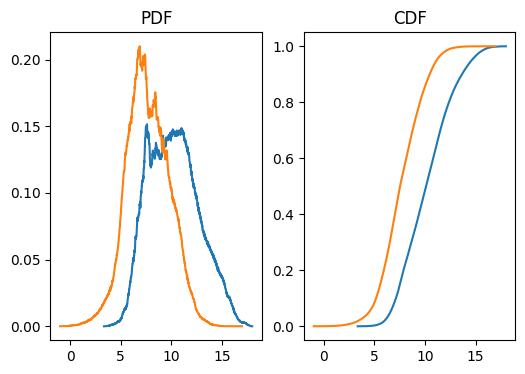

In [66]:
plt.figure(figsize=(6,4))
plot_cdf_pdf(upwelling[0].T, downwelling[0].T)

Cluster label: 0
	O2 Upwelling: 216.1
	O2 Downwelling: 244.9
	OmegaA Upwelling: 1.5
	OmegaA Downwelling: 1.5
	T Upwelling: 14.6
	T Downwelling: 11.2
Cluster label: 1
	O2 Upwelling: 47.3
	O2 Downwelling: 57.2
	OmegaA Upwelling: 0.8
	OmegaA Downwelling: 0.8
	T Upwelling: 6.6
	T Downwelling: 7.6


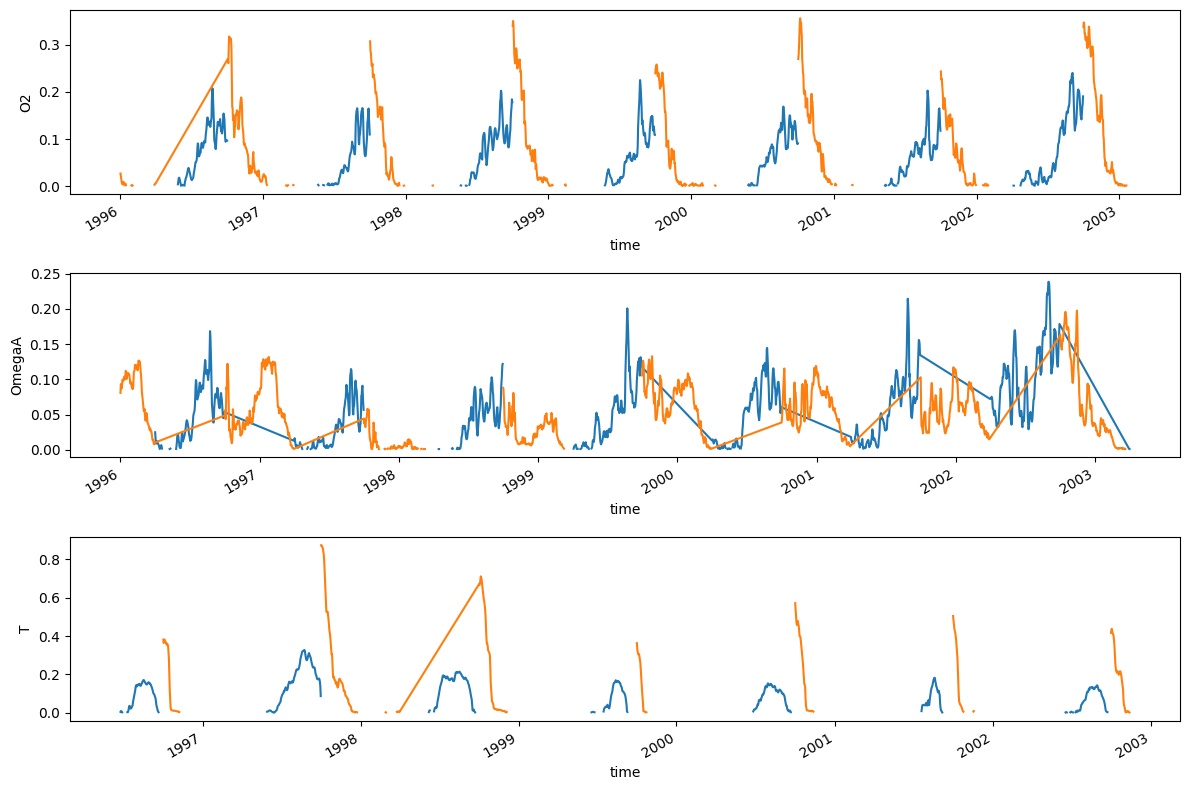

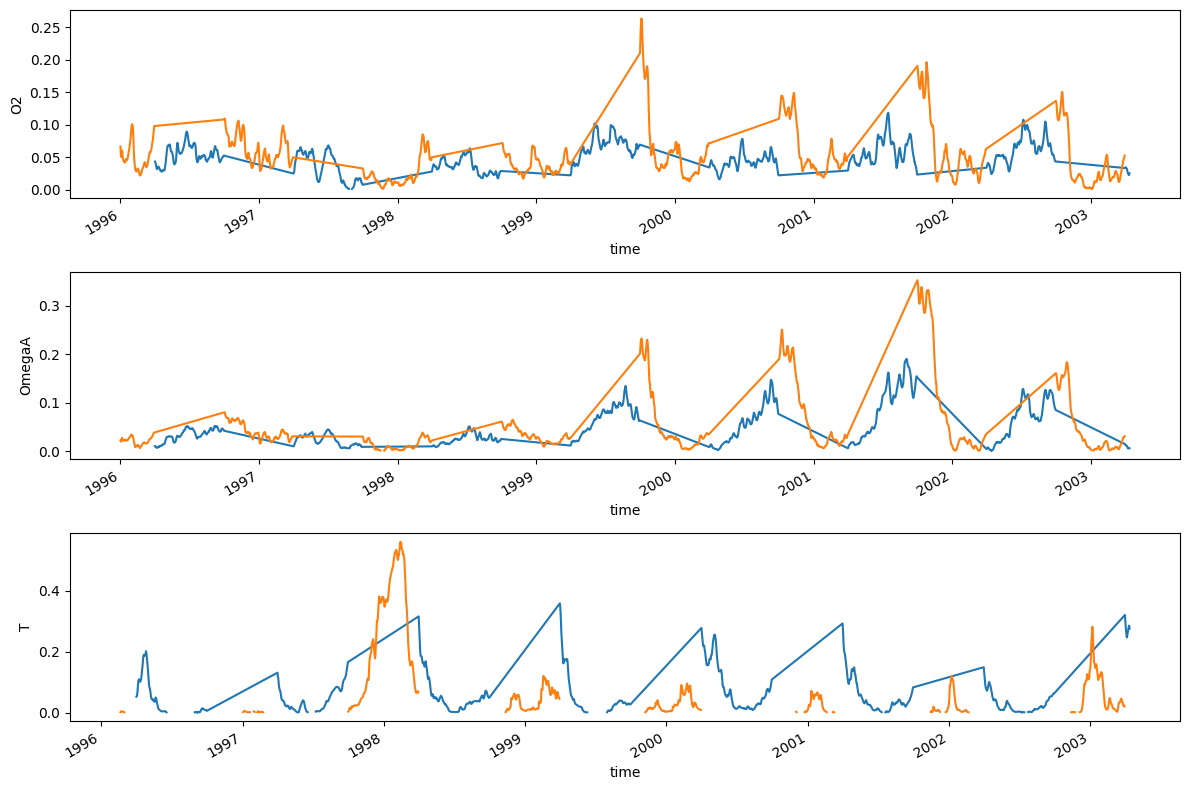

In [83]:
# Calculate extreme thresholds by upwelling/downwelling season and plot timeseries of percentage extremes
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

base_percentile = 0.05
percentiles = {
    'O2':base_percentile,
    'OmegaA':base_percentile,
    'T':1-base_percentile
}

def calculate_threshold(ds, percentile, nbins=1000):
    data = ds.to_numpy().flatten()
    hist, edges = np.histogram(data, bins=nbins, density=True)
    cdf = integrate.cumtrapz(hist,edges[1:])
    return np.interp(percentile, cdf, edges[2:])    

def plot_fraction_extreme(ds, threshold, plot_months, extreme_is_low, label):
    if extreme_is_low:
        is_extreme = ds <= threshold
    else:
        is_extreme = ds >= threshold    
    npts = len(ds.stacked_y_x)
    frac_extreme = is_extreme.sum('stacked_y_x')/npts
    frac_extreme = frac_extreme.where(frac_extreme['time.month'].isin(plot_months))
    frac_extreme = frac_extreme.where(frac_extreme > 0.001)
    # frac_extreme.groupby('time.year').mean(dim='time').plot(label=label, marker='o')     
    frac_extreme.plot(label=label)     
    

upwelling = {}
downwelling = {}

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        ds_months = cluster_ds.groupby('time.month')
        
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')
        plt.figure(figsize=(12,8))
                   
        for idx, var in enumerate(timeseries_vars):         
            plt.subplot(3,1,idx+1)
            if idx == 0:
                plt.title(f'Cluster: {cluster_label}')
            percentile = percentiles[var]
            upwelling_threshold = calculate_threshold(upwelling_ds[var],percentile)
            downwelling_threshold = calculate_threshold(downwelling_ds[var],percentile)
            print(f'\t{var} Upwelling: {upwelling_threshold:.1f}')
            print(f'\t{var} Downwelling: {downwelling_threshold:.1f}')
            plot_fraction_extreme(upwelling_ds[var], upwelling_threshold, upwelling_months, percentile == base_percentile, 'Upwelling')
            plot_fraction_extreme(downwelling_ds[var], downwelling_threshold, downwelling_months, percentile == base_percentile, 'Downwelling')
        plt.tight_layout()
